In [29]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.layers import LSTM

# Carga y Preparación de data

In [3]:
consumo = pd.read_excel("CONSUMO-2024-06.xlsx", skiprows = 6)
importacion = pd.read_excel("IMPORTACION-VOLUMEN-2024-06.xlsx", skiprows = 6)
precios2024 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2024", skiprows = 9, header = None, 
                        names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2023 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2023", skiprows = 9, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2022 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2022", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2021 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2021", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])

In [4]:
precios2024.drop(precios2024.tail(9).index, inplace = True)
precios2023.drop(precios2023.tail(2).index, inplace = True)
precios2022.drop(precios2022.tail(2).index, inplace = True)
precios2021.drop(precios2021.tail(2).index, inplace = True)

In [5]:
precios = pd.concat([precios2021, precios2022, precios2023, precios2024], ignore_index = True)

In [6]:
#Se suman los consumos de Diesel, ya que de 2000 a 2018 se consumía alto en azufre y a partir de enero 2018 se consumía bajo en azufre
consumo["Diesel"] = consumo["Diesel bajo azufre"]+consumo["Diesel alto azufre"]
importacion["Diesel"] = importacion["Diesel bajo azufre"]+importacion["Diesel alto azufre"]

In [7]:
consumo = consumo[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
importacion = importacion[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
precios = precios[["Fecha", "Diesel", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", "Regular", "Superior"]].copy()

In [8]:
consumo.drop(consumo.tail(3).index, inplace = True)
importacion.drop(importacion.tail(3).index, inplace = True)

In [9]:
consumo["Fecha"] = pd.to_datetime(consumo["Fecha"])
importacion["Fecha"] = pd.to_datetime(importacion["Fecha"])
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

# Modelos LSTM

In [10]:
tf.random.set_seed(1122)

## Consumo Gasolina Regular

In [11]:
regular = consumo[["Fecha", "Gasolina regular"]].copy()
regular.set_index("Fecha", inplace = True)
regular.head()


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


In [12]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
regularTest = adfuller(regular, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba          2.430669
p-value                        0.999024
# de retardos usados          14.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [13]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
regular_diff = regular.diff()
regular_diff.fillna(0,inplace = True)
regularTest = adfuller(regular_diff, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba         -4.316925
p-value                        0.000415
# de retardos usados          16.000000
# de observaciones usadas    277.000000
Critical Value (1%)           -3.454180
Critical Value (5%)           -2.872031
Critical Value (10%)          -2.572360
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

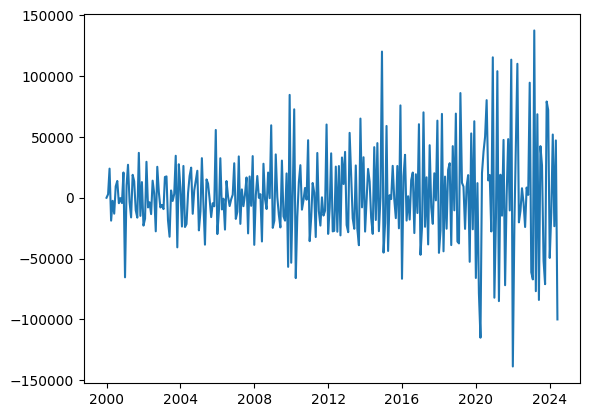

In [14]:
plt.plot(regular_diff)

In [15]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff)

Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [16]:
num_separacion = consumo.index[consumo["Fecha"]==pd.to_datetime("2021-12")][0]
train = regular_diff_scaled[:num_separacion]
test = regular_diff_scaled[num_separacion:]

In [17]:
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))

In [18]:
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)

x_test,y_test = supervisada(test)

## Creación del modelo

In [19]:
#transformación a matrices de 3 dimensiones
x_train = np.reshape(x_train,(x_train.shape[0],1,1))

x_test = np.reshape(x_test, (x_test.shape[0],1,1))

In [21]:
x_train.shape

(263, 1, 1)

In [31]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(InputLayer(batch_input_shape=(lote,paso,caracteristicas)))
modelo1.add(LSTM(unidades,stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (1, 1)                 │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [33]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    verbose=1
)

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4414
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4249
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4133
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4053
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4000
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3963
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3928
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3882
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3825
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3759
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3688
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3616
Epoch 13/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3544
Epoch 14/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3475
Epoch 15/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

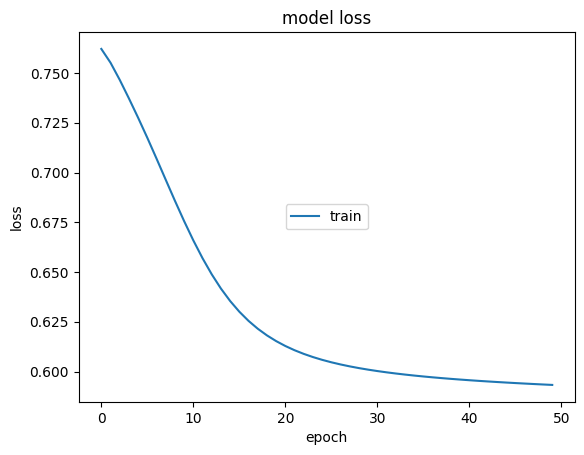

In [25]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='center')

In [26]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento


ValueError: Exception encountered when calling LSTM.call().

[1mInput tensor `sequential_1/lstm_1/ReadVariableOp:0` enters the loop with shape (1, 1), but has shape (None, 1) after one iteration. To allow the shape to vary across iterations, use the `shape_invariants` argument of tf.while_loop to specify a less-specific shape.[0m

Arguments received by LSTM.call():
  • sequences=tf.Tensor(shape=(None, 1, 1), dtype=float32)
  • initial_state=None
  • mask=None
  • training=False

## Importación Diesel

In [ ]:
diesel = importacion[['Fecha', 'Diesel']].copy()
diesel.set_index('Fecha', inplace = True)

train_size = int(len(diesel) * 0.8)
train_diesel = diesel[0:train_size]
test_diesel = diesel[train_size:len(diesel)]

ts_diesel = train_diesel['Diesel']